# Custom Notebook 6 Transfer Learning

Goals:


*   Download images from kaggle into Google Drive
    * Learn how to mount to google drive and access images in google drive
* Load into pytorch dataset
* Download imagenet model from pytorch
* Do transfer learning



In [1]:
import torch
import torch.nn
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
# define device and seed
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(42)

# Mount to Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Download From Kaggle Then Put It Into Drive

https://www.kaggle.com/datasets/gpiosenka/sports-classification

In [4]:
import os

In [5]:
os.listdir()

['.config', 'drive', 'sample_data']

In [6]:
os.listdir(os.path.join('drive'))

['MyDrive', '.shortcut-targets-by-id', '.Trash-0', '.Encrypted']

In [7]:
os.listdir(os.path.join('drive', 'MyDrive'))

['The Rise of the Phoenix.gdoc',
 'Colab Notebooks',
 'Movies',
 'Videos',
 'PC.gdoc',
 'PC.gsheet',
 'Videos (1)',
 'Copy of Banned Books Essay- Self Checklist.gdoc',
 'Copy of Pathak Saket - Book Censorship: Argumentative Essay.gdoc',
 'python learning.gsite',
 'Valley Essay 1.gdoc',
 'Classroom',
 'AMC 10 TEST A 2022.gdoc',
 'Untitled presentation (6).gslides',
 'Untitled document (33).gdoc',
 'about.gdoc',
 'Untitled document (32).gdoc',
 'Untitled presentation (5).gslides',
 'Untitled presentation - Line chart 1.gsheet',
 'Untitled presentation (4).gslides',
 'cookie clicker.gdoc',
 'Untitled document (31).gdoc',
 'Untitled presentation (3).gslides',
 'Untitled presentation (2).gslides',
 'Untitled document (30).gdoc',
 'Untitled document (29).gdoc',
 'List of Components (1).gsheet',
 'List of Components.gsheet',
 'Untitled document (28).gdoc',
 'PRosthetic Arm.pptx',
 'Abraham Ryan - Team Slide Deck of Activity Log.gslides',
 'project.gslides',
 'Prosthetic.gslides',
 'summary fo

In [8]:
os.listdir(os.path.join('drive', 'MyDrive', 'COSMOS 25 Cluster 11 Brain Inspired Machine Learning', 'Datasets'))

['archive.zip', 'archive']

In [9]:
data_path = os.path.join('drive', 'MyDrive', 'COSMOS 25 Cluster 11 Brain Inspired Machine Learning', 'Datasets')

# Extract the Zipped Dataset in your Drive

In [10]:
import zipfile

# Path to the zip file and where to extract
zip_path = os.path.join(data_path, 'archive.zip')
extract_to = os.path.join(data_path, 'archive')

# Check if it already exists
if not os.path.exists(extract_to):
    print("Extracting ZIP...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Extraction complete.")
else:
    print("ZIP already extracted")

ZIP already extracted


In [11]:
os.listdir(data_path)

['archive.zip', 'archive']

In [12]:
sports_data_path = os.path.join(data_path, 'archive')

In [13]:
print(os.listdir(os.path.join(sports_data_path, "train")))
print(len(os.listdir(os.path.join(sports_data_path, "train"))))
print(os.listdir(os.path.join(sports_data_path, "test")))
print(len(os.listdir(os.path.join(sports_data_path, "test"))))

['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling', 'bike polo', 'billiards', 'bmx', 'bobsled', 'bowling', 'boxing', 'bull riding', 'bungee jumping', 'canoe slamon', 'cheerleading', 'chuckwagon racing', 'cricket', 'croquet', 'curling', 'disc golf', 'fencing', 'field hockey', 'figure skating men', 'figure skating pairs', 'figure skating women', 'fly fishing', 'football', 'formula 1 racing', 'frisbee', 'gaga', 'giant slalom', 'golf', 'hammer throw', 'hang gliding', 'harness racing', 'high jump', 'hockey', 'horse jumping', 'horse racing', 'horseshoe pitching', 'hurdles', 'hydroplane racing', 'ice climbing', 'ice yachting', 'jai alai', 'javelin', 'jousting', 'judo', 'lacrosse', 'log rolling', 'luge', 'motorcycle racing', 'mushing', 'nascar racing', 'olympic wrestling', 'parallel bar', 'pole climbing', 'pole dancing', 'pole vault', 'polo', 'pommel horse', 'rings', 'rock climbing', 'roller 

# Create a Custom Dataset

In [14]:
from torch.utils.data import Dataset
from PIL import Image

Overrid init, len, getitem
https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

In [15]:
class SportsDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        # Get sorted list of class folder names
        self.classes = sorted([
            d for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d))
        ])

        # Map class names to integer labels
        self.class_to_labels = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

        # Colllect all images paths and labels
        for cls_name in self.classes:
            cls_dir = os.path.join(root_dir, cls_name)
            for fname in os.listdir(cls_dir):
                fpath = os.path.join(cls_dir, fname)
                if os.path.isfile(fpath) and fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.samples.append((fpath, self.class_to_labels[cls_name]))

    # overide length
    def __len__(self):
        return len(self.samples)

    # overide get item
    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [16]:
[x for x in range(10)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Transformations

https://docs.pytorch.org/vision/main/transforms.html

https://docs.pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html

In [17]:
from torchvision import transforms

In [18]:
# composite the transforms include data augmentation
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([
        transforms.RandomRotation(30),
        transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), shear=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.GaussianBlur(kernel_size=5)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.25), ratio=(0.3, 3.3)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [19]:
trainset = SportsDataset(os.path.join(sports_data_path, 'train'), transform=train_transform)
valset = SportsDataset(os.path.join(sports_data_path, 'valid'), transform=val_transform)

In [20]:
class Denormalize:
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(3, 1, 1)
        self.std = torch.tensor(std).view(3, 1, 1)

    def __call__(self, tensor):
        return tensor * self.std + self.mean

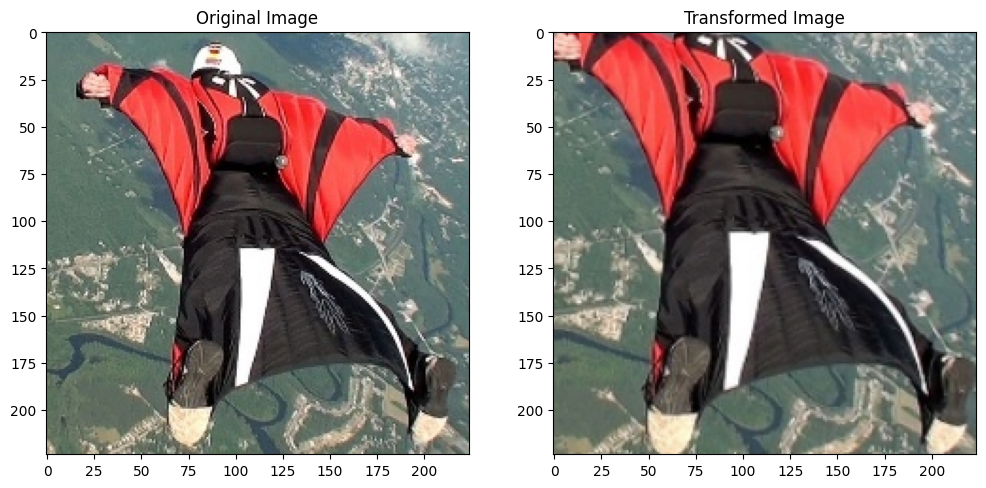

In [21]:
# load in any image (replace with your own image path)
image_path = os.path.join(sports_data_path, 'test', 'wingsuit flying', '5.jpg')
image = Image.open(image_path)

# apply the transform to the image
transformed_image = train_transform(image)

denorm = Denormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# call denorm
image_denorm = denorm(transformed_image)

# visualize the original and transformed image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # row, col, figsize
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[1].imshow(image_denorm.permute(1, 2, 0))
ax[1].set_title("Transformed Image")
plt.show()

In [22]:
from torch.utils.data import DataLoader

In [23]:
loader = DataLoader(trainset, batch_size=8, shuffle=True, drop_last=True)

images, labels = next(iter(loader))

print(images.shape, labels.shape)

torch.Size([8, 3, 224, 224]) torch.Size([8])


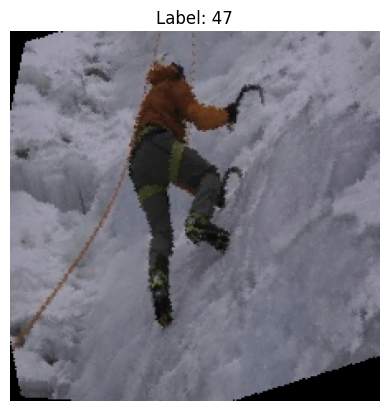

In [24]:
# get first image
img = images[0]

img = denorm(img).permute(1,2,0)

# show image
plt.imshow(img)
plt.title(f"Label: {labels[0]}")
plt.axis("off")
plt.show()

# Transfer Learning

In [25]:
from torch.utils.data import Subset

In [26]:
# # optional: use simpler transform for speed
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),  # this rescales it to the range 0-1
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

full_trainset = SportsDataset(os.path.join(sports_data_path, 'train'), transform=train_transform)

# Use only 10% of the training data
subset_size = int(0.1 * len(full_trainset))  # e.g., 6000 out of 60000
subset_indices = np.random.choice(len(full_trainset), subset_size, replace=False)
trainset = Subset(full_trainset, subset_indices)

valset = SportsDataset(os.path.join(sports_data_path, 'valid'), transform=val_transform)
testset = SportsDataset(os.path.join(sports_data_path, 'test'), transform=val_transform)

In [27]:
print(len(trainset))
print(len(valset))
print(len(testset))

1349
500
500


In [28]:
batch_size = 100
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, drop_last=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, drop_last=True)

Choose a model from torchvision

https://docs.pytorch.org/vision/main/models.html

https://docs.pytorch.org/vision/main/models/generated/torchvision.models.vgg11_bn.html#torchvision.models.VGG11_BN_Weights

In [29]:
from torchvision.models import vgg11_bn, VGG11_BN_Weights

Print VGG model details

In [30]:
test_model = vgg11_bn(weights=VGG11_BN_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:06<00:00, 87.8MB/s]


In [31]:
print(test_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

Define New Model that Freezes the Featurizer and Replaces the Classifier

In [32]:
import torch.nn as nn

In [33]:
class Net(nn.Module):
    def __init__(self, num_classes=100):
        super(Net, self).__init__()
        self.base_model = vgg11_bn(weights=VGG11_BN_Weights.IMAGENET1K_V1)

        # Freeze Featurizer
        for param in self.base_model.features.parameters():
            param.requires_grad = False

        # Replace Classifier
        self.base_model.classifier = nn.Sequential(
            nn.Linear(25088, 1280, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1280, 100, bias=True)
        )

        for params in self.base_model.classifier.parameters():
            params.requires_grad= True

    def forward(self, x):
        outputs = self.base_model(x)
        return outputs

In [34]:
model = Net()
print(model)

Net(
  (base_model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

Training Loop

In [35]:
num_epochs = 10  # lower this if you only have access to cpu
model = model.to(device)
optimizer = torch.optim.Adam(model.base_model.parameters())
loss_fn = nn.CrossEntropyLoss()

In [36]:
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            predicted = outputs.data.argmax(dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total if total > 0 else 0

In [37]:
from tqdm import tqdm

In [ ]:
# save loss and accuracies
train_losses = []
train_acc = []

num_batches = len(trainloader)

for epoch in range(num_epochs):
    model.train()

    # initialize stats
    running_loss = 0.0
    correct = 0
    total = 0

    print('--------')
    print(f"Epoch {epoch}")
    print('--------')

    pbar = tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for images, targets in pbar:
        images = images.to(device)
        targets = targets.to(device)

        # zero out gradients
        optimizer.zero_grad()

        # forward pass
        preds = model(images)

        # calculate loss and update weights
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        # calculate accuracy and loss
        running_loss += loss.item()
        _, predicted = torch.max(preds.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

        # record history
        train_losses.append(running_loss/(pbar.n+1))

        pbar.set_postfix({'Loss': f'{running_loss/(pbar.n+1):.4f}', 'Acc': f'{100.*correct/total:.2f}%'})

    # validation accuracy
    val_acc = calculate_accuracy(valloader, model)
    print(f'{val_acc:.4f}%')

# How to save your model

In [ ]:
save_to = os.path.join('drive', 'MyDrive', 'COSMOS 25 Cluster 11 Brain Inspired Machine Learning', 'Models', "sports_model_weights.pth")

# save weights
torch.save(model.state_dict(), save_to)

# How to load your model

In [38]:
model = Net()

load_from =  os.path.join('drive', 'MyDrive', 'COSMOS 25 Cluster 11 Brain Inspired Machine Learning', 'Models', "sports_model_weights.pth")

# Load weights
model.load_state_dict(torch.load(load_from, map_location = torch.device('cpu')))

# Optional: set to eval mode
model.eval()

Net(
  (base_model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

# Finish this notebook by doing the following:
* Plot the loss
* Check the model's accuracy on the test dataset
* Download 10 images of some recent sport events (i.e. images from  basketball games this week), feed it into the model and see if it gets the correct answer. Report the accuracy of those 10 images.

In [ ]:
plt.plot(train_losses)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [39]:
calculate_accuracy(testloader, model)

69.8

In [39]:
newtestset = SportsDataset(os.path.join(sports_data_path, 'newtest'), transform=val_transform)

newtestloader = DataLoader(newtestset, batch_size=10, shuffle=False)

In [40]:
dataiter = iter(newtestloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Forward pass
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Display image
def imshow(img, idx):
    img = img.cpu()  # move to CPU for plotting
    img = img.permute(1, 2, 0)  # (C, H, W) -> (H, W, C)
    plt.imshow(img)
    plt.axis('off')
    print(labels[0].item())
    plt.title(f"True: {labels[idx].item()} | Predicted: {predicted[idx].item()}")
    plt.show()
idx_ = 5
imshow(images[idx_], idx_)
print(len(labels))
print(labels)
print(predicted)


FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/COSMOS 25 Cluster 11 Brain Inspired Machine Learning/Datasets/archive/newtest/basketball/b1 (1).jpg'